In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [2]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical

import numpy as np
import pickle
from torch.utils.data import DataLoader, Dataset

import sys 
# sys.path.append('..')
# from models.GACNet.modules import GACNet, get_loss

import torch
import random

In [3]:
from tensorflow.keras import backend as K
from collections import Counter
def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing import sequence

atom_dict_ = {'H': 0,
         'C': 1,
         'O': 2,
         'N': 3,
         'S': 4}

In [4]:
with open('../../ms_final/ss/data/atom_ss_X.pkl', 'rb') as handle:
    X = pickle.load(handle)
with open('../../ms_final/ss/data/atom_ss_y.pkl', 'rb') as handle:
    y = pickle.load(handle)

In [5]:
normalize = True
for idx in range(len(X)):
    cur_coord = []
    cur_feat = []
    
    cur_x = X[idx]
    for i in cur_x:
        a = i[0]
        b = i[1]
        c = i[2]
        cur_coord.append([a, b, c])
        
        atom = i[3]
        zeros = [0 for _ in range(5)]
        if atom in atom_dict_:
            zeros[atom_dict_[atom]] = 1
        cur_feat.append(zeros)
        
    xyz = np.asarray(cur_coord, dtype = np.float32)
    norm = np.asarray(cur_feat, dtype = np.int32)
        
    centroid = np.mean(xyz, axis=0)
    xyz -= centroid
    if normalize:
        m = np.max(np.sqrt(np.sum(xyz**2, axis=1)))
        xyz = xyz / m
    
    points = np.concatenate([xyz, norm], 1)
    X[idx] = points

In [6]:
max_len = 4000

In [7]:
input_data = sequence.pad_sequences(X, maxlen=max_len, padding='post', dtype='float32', truncating='post')
tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(y)
target_data = tokenizer_decoder.texts_to_sequences(y)
# target_data = sequence.pad_sequences(target_data, maxlen=max_len, padding='post', truncating='post')

In [8]:
target_data_ = sequence.pad_sequences(target_data, maxlen=max_len, padding='post', truncating='post')

In [9]:
y = []
for i in target_data:
    y.append(list(set(i)))

In [11]:
for cls in range(1, 9):
    cnt = 0
    for i in y:
        if cls in i:
            cnt += 1
    print(cls, cnt)

1 12482
2 11264
3 13367
4 13231
5 13091
6 10849
7 8353
8 2478


In [14]:
print(len(y))

13367


In [12]:
idx_7, idx_8 = [], []
for i in range(len(y)):
    ele = y[i]
    if 7 in ele and 8 not in ele:
        idx_7.append(i)
    if 8 in ele and 7 not in ele:
        idx_8.append(i)
print(len(idx_7), len(idx_8))

6638 763


In [13]:
idx_6, idx_7 = [], []
for i in range(len(y)):
    ele = y[i]
    if 6 in ele and 7 not in ele:
        idx_6.append(i)
    if 7 in ele and 6 not in ele:
        idx_7.append(i)
print(len(idx_6), len(idx_7))

3431 935


In [24]:
idx_6, idx_7 = idx_6[:900], idx_7[:900]
print(len(idx_6), len(idx_7))

900 900


In [15]:
idx_1, idx_2 = [], []
for i in range(len(y)):
    ele = y[i]
    if 1 in ele and 2 not in ele:
        idx_1.append(i)
    if 2 in ele and 1 not in ele:
        idx_2.append(i)
print(len(idx_1), len(idx_2))

2063 845


In [27]:
used = np.concatenate([input_data[idx_6],input_data[idx_7]])
y = [0]*900 + [1]*900
y = np.array(y)
print(len(used), len(y))

1800 1800


In [20]:
from models.GACNet.modules import GACNet, get_loss

/homes/songhao.jiang/anaconda3/envs/pc/lib/python3.8/site-packages/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


In [28]:
X_train, X_test, y_train, y_test = train_test_split(used, y, test_size=.2, random_state=0)
X_train.shape, y_train.shape

((1440, 4000, 8), (1440,))

In [29]:
class PC_dataset(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        pc = self.x[idx]
        label = self.y[idx]

        return pc, label

train_dataset = PC_dataset(X_train, y_train)
test_dataset = PC_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [30]:
NUM_CLASSES = 2

classifier = GACNet(NUM_CLASSES).cuda()
#criterion = get_loss()
# criterion = torch.nn.BCELoss().cuda()
criterion = get_loss().cuda()

optimizer = torch.optim.Adam(
    classifier.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-07,
    weight_decay=0
)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0.0)

def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True
classifier = classifier.apply(inplace_relu)
classifier = classifier.apply(weights_init)

In [31]:
train_hist_loss = []
train_hist_acc = []
test_hist_acc = []
for epoch in range(150):
    num_batches = len(train_loader)
    total_correct = 0
    total_seen = 0
    loss_sum = 0
    classifier = classifier.train()
    mean_correct = []
    total_loss = 0
    for i, (points, target) in tqdm(enumerate(train_loader), total=len(train_loader), smoothing=0.9):
        optimizer.zero_grad()

        #points = points.data.numpy()
        #points = torch.Tensor(points)
        points = points.transpose(2, 1)
        norm = points[:, 3:, :]
        xyz = points[:, :3, :]
        
        xyz, norm, target = xyz.float().cuda(), norm.float().cuda(), target.long().cuda()
        #print(xyz.shape, norm.shape)
        pred = classifier(xyz, norm)
        loss = criterion(pred, target.long())


        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().detach().data.item()
    train_instance_acc = np.mean(mean_correct)
    train_hist_acc.append(train_instance_acc)
    train_hist_loss.append(total_loss)
    print("Epoch: {}".format(epoch+1))
    print('Train Instance Accuracy: %f' % train_instance_acc)
    print('Train Loss: %f' % total_loss)
    
    mean_correct_test = []
    with torch.no_grad():
        for i, (points, target) in enumerate(test_loader):

            points = points.transpose(2, 1)
            norm = points[:, 3:, :]
            xyz = points[:, :3, :]

            xyz, norm, target = xyz.float().cuda(), norm.float().cuda(), target.long().cuda()
            pred = classifier(xyz, norm)


            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.long().data).cpu().sum()
            mean_correct_test.append(correct.item() / float(points.size()[0]))
        test_instance_acc = np.mean(mean_correct_test)
        test_hist_acc.append(test_instance_acc)
        #print("Epoch: {}".format(epoch+1))
        print('Test Instance Accuracy: %f' % test_instance_acc)

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 1
Train Instance Accuracy: 0.512500
Train Loss: 79.290829
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 2
Train Instance Accuracy: 0.513194
Train Loss: 71.799314
Test Instance Accuracy: 0.497283


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 3
Train Instance Accuracy: 0.530556
Train Loss: 67.510218
Test Instance Accuracy: 0.508152


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 4
Train Instance Accuracy: 0.508333
Train Loss: 66.737882
Test Instance Accuracy: 0.521739


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 5
Train Instance Accuracy: 0.509722
Train Loss: 65.672697
Test Instance Accuracy: 0.595109


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 6
Train Instance Accuracy: 0.534028
Train Loss: 64.592834
Test Instance Accuracy: 0.510870


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 7
Train Instance Accuracy: 0.504167
Train Loss: 64.741444
Test Instance Accuracy: 0.497283


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 8
Train Instance Accuracy: 0.515972
Train Loss: 63.741894
Test Instance Accuracy: 0.497283


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 9
Train Instance Accuracy: 0.531250
Train Loss: 62.976244
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 10
Train Instance Accuracy: 0.513194
Train Loss: 63.351093
Test Instance Accuracy: 0.562500


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 11
Train Instance Accuracy: 0.531944
Train Loss: 62.976421
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 12
Train Instance Accuracy: 0.517361
Train Loss: 63.224719
Test Instance Accuracy: 0.486413


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 13
Train Instance Accuracy: 0.527083
Train Loss: 62.280930
Test Instance Accuracy: 0.578804


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 14
Train Instance Accuracy: 0.541667
Train Loss: 62.137739
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 15
Train Instance Accuracy: 0.554861
Train Loss: 61.862980
Test Instance Accuracy: 0.562500


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 16
Train Instance Accuracy: 0.517361
Train Loss: 62.308108
Test Instance Accuracy: 0.573370


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 17
Train Instance Accuracy: 0.537500
Train Loss: 62.127905
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 18
Train Instance Accuracy: 0.538889
Train Loss: 62.075134
Test Instance Accuracy: 0.510870


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 19
Train Instance Accuracy: 0.555556
Train Loss: 61.495762
Test Instance Accuracy: 0.510870


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 20
Train Instance Accuracy: 0.531944
Train Loss: 62.049841
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 21
Train Instance Accuracy: 0.556250
Train Loss: 61.772460
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 22
Train Instance Accuracy: 0.553472
Train Loss: 61.565825
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 23
Train Instance Accuracy: 0.544444
Train Loss: 61.469168
Test Instance Accuracy: 0.497283


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 24
Train Instance Accuracy: 0.542361
Train Loss: 61.992202
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 25
Train Instance Accuracy: 0.530556
Train Loss: 61.974561
Test Instance Accuracy: 0.502717


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 26
Train Instance Accuracy: 0.535417
Train Loss: 61.471525
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 27
Train Instance Accuracy: 0.524306
Train Loss: 62.020658
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 28
Train Instance Accuracy: 0.554167
Train Loss: 61.736861
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 29
Train Instance Accuracy: 0.540278
Train Loss: 61.928658
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 30
Train Instance Accuracy: 0.534722
Train Loss: 62.238102
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 31
Train Instance Accuracy: 0.540972
Train Loss: 61.678933
Test Instance Accuracy: 0.513587


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 32
Train Instance Accuracy: 0.552778
Train Loss: 61.666068
Test Instance Accuracy: 0.516304


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 33
Train Instance Accuracy: 0.544444
Train Loss: 61.213540
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 34
Train Instance Accuracy: 0.547222
Train Loss: 62.018807
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 35
Train Instance Accuracy: 0.552778
Train Loss: 61.550210
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 36
Train Instance Accuracy: 0.539583
Train Loss: 61.588462
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 37
Train Instance Accuracy: 0.565278
Train Loss: 61.223483
Test Instance Accuracy: 0.578804


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 38
Train Instance Accuracy: 0.564583
Train Loss: 61.729138
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 39
Train Instance Accuracy: 0.565972
Train Loss: 61.698569
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 40
Train Instance Accuracy: 0.539583
Train Loss: 61.791834
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 41
Train Instance Accuracy: 0.550694
Train Loss: 61.517355
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 42
Train Instance Accuracy: 0.559028
Train Loss: 60.944969
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 43
Train Instance Accuracy: 0.565278
Train Loss: 61.320706
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 44
Train Instance Accuracy: 0.550694
Train Loss: 61.223045
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 45
Train Instance Accuracy: 0.547917
Train Loss: 61.795240
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 46
Train Instance Accuracy: 0.552778
Train Loss: 61.429527
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 47
Train Instance Accuracy: 0.568056
Train Loss: 61.443194
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 48
Train Instance Accuracy: 0.560417
Train Loss: 61.562411
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 49
Train Instance Accuracy: 0.539583
Train Loss: 61.748369
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 50
Train Instance Accuracy: 0.568056
Train Loss: 61.363004
Test Instance Accuracy: 0.573370


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 51
Train Instance Accuracy: 0.558333
Train Loss: 61.471513
Test Instance Accuracy: 0.502717


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 52
Train Instance Accuracy: 0.564583
Train Loss: 61.220012
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 53
Train Instance Accuracy: 0.578472
Train Loss: 61.210445
Test Instance Accuracy: 0.565217


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 54
Train Instance Accuracy: 0.574306
Train Loss: 60.885116
Test Instance Accuracy: 0.508152


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 55
Train Instance Accuracy: 0.572222
Train Loss: 61.164251
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 56
Train Instance Accuracy: 0.569444
Train Loss: 61.790918
Test Instance Accuracy: 0.567935


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 57
Train Instance Accuracy: 0.569444
Train Loss: 61.513109
Test Instance Accuracy: 0.529891


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 58
Train Instance Accuracy: 0.559028
Train Loss: 61.582537
Test Instance Accuracy: 0.505435


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 59
Train Instance Accuracy: 0.549306
Train Loss: 61.700227
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 60
Train Instance Accuracy: 0.577778
Train Loss: 61.451214
Test Instance Accuracy: 0.513587


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 61
Train Instance Accuracy: 0.566667
Train Loss: 61.508777
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 62
Train Instance Accuracy: 0.562500
Train Loss: 61.548658
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 63
Train Instance Accuracy: 0.542361
Train Loss: 61.853692
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 64
Train Instance Accuracy: 0.562500
Train Loss: 61.572553
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 65
Train Instance Accuracy: 0.577083
Train Loss: 60.960107
Test Instance Accuracy: 0.567935


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 66
Train Instance Accuracy: 0.565278
Train Loss: 61.449844
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 67
Train Instance Accuracy: 0.569444
Train Loss: 61.375442
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 68
Train Instance Accuracy: 0.583333
Train Loss: 60.757953
Test Instance Accuracy: 0.470109


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 69
Train Instance Accuracy: 0.564583
Train Loss: 60.985031
Test Instance Accuracy: 0.505435


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 70
Train Instance Accuracy: 0.571528
Train Loss: 61.050836
Test Instance Accuracy: 0.494565


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 71
Train Instance Accuracy: 0.549306
Train Loss: 61.644960
Test Instance Accuracy: 0.529891


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 72
Train Instance Accuracy: 0.542361
Train Loss: 61.336105
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 73
Train Instance Accuracy: 0.588194
Train Loss: 60.657896
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 74
Train Instance Accuracy: 0.588194
Train Loss: 61.275488
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 75
Train Instance Accuracy: 0.564583
Train Loss: 61.223414
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 76
Train Instance Accuracy: 0.545833
Train Loss: 61.632739
Test Instance Accuracy: 0.508152


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 77
Train Instance Accuracy: 0.591667
Train Loss: 60.019565
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 78
Train Instance Accuracy: 0.572917
Train Loss: 60.669076
Test Instance Accuracy: 0.527174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 79
Train Instance Accuracy: 0.580556
Train Loss: 61.130484
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 80
Train Instance Accuracy: 0.567361
Train Loss: 60.900268
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 81
Train Instance Accuracy: 0.573611
Train Loss: 60.524446
Test Instance Accuracy: 0.513587


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 82
Train Instance Accuracy: 0.572222
Train Loss: 60.900223
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 83
Train Instance Accuracy: 0.587500
Train Loss: 60.907445
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 84
Train Instance Accuracy: 0.577778
Train Loss: 60.553922
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 85
Train Instance Accuracy: 0.560417
Train Loss: 61.168618
Test Instance Accuracy: 0.489130


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 86
Train Instance Accuracy: 0.590278
Train Loss: 60.272328
Test Instance Accuracy: 0.521739


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 87
Train Instance Accuracy: 0.565972
Train Loss: 61.117052
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 88
Train Instance Accuracy: 0.597222
Train Loss: 60.279502
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 89
Train Instance Accuracy: 0.604861
Train Loss: 60.330174
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 90
Train Instance Accuracy: 0.584722
Train Loss: 60.846148
Test Instance Accuracy: 0.527174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 91
Train Instance Accuracy: 0.579167
Train Loss: 60.315805
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 92
Train Instance Accuracy: 0.597917
Train Loss: 61.014723
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 93
Train Instance Accuracy: 0.593056
Train Loss: 60.338754
Test Instance Accuracy: 0.529891


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 94
Train Instance Accuracy: 0.595833
Train Loss: 59.595770
Test Instance Accuracy: 0.510870


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 95
Train Instance Accuracy: 0.619444
Train Loss: 59.211335
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 96
Train Instance Accuracy: 0.588194
Train Loss: 60.307235
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 97
Train Instance Accuracy: 0.590278
Train Loss: 59.969926
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 98
Train Instance Accuracy: 0.577083
Train Loss: 60.953718
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 99
Train Instance Accuracy: 0.593750
Train Loss: 59.984960
Test Instance Accuracy: 0.510870


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 100
Train Instance Accuracy: 0.620833
Train Loss: 59.013243
Test Instance Accuracy: 0.513587


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 101
Train Instance Accuracy: 0.599306
Train Loss: 59.742585
Test Instance Accuracy: 0.576087


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 102
Train Instance Accuracy: 0.601389
Train Loss: 60.052842
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 103
Train Instance Accuracy: 0.611806
Train Loss: 59.730779
Test Instance Accuracy: 0.527174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 104
Train Instance Accuracy: 0.597917
Train Loss: 59.667045
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 105
Train Instance Accuracy: 0.616667
Train Loss: 58.740435
Test Instance Accuracy: 0.521739


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 106
Train Instance Accuracy: 0.627778
Train Loss: 58.104013
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 107
Train Instance Accuracy: 0.597917
Train Loss: 58.859693
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 108
Train Instance Accuracy: 0.623611
Train Loss: 58.492363
Test Instance Accuracy: 0.508152


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 109
Train Instance Accuracy: 0.631250
Train Loss: 58.513214
Test Instance Accuracy: 0.562500


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 110
Train Instance Accuracy: 0.631944
Train Loss: 58.214405
Test Instance Accuracy: 0.516304


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 111
Train Instance Accuracy: 0.621528
Train Loss: 58.745737
Test Instance Accuracy: 0.516304


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 112
Train Instance Accuracy: 0.653472
Train Loss: 57.349196
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 113
Train Instance Accuracy: 0.637500
Train Loss: 58.527038
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 114
Train Instance Accuracy: 0.639583
Train Loss: 57.379543
Test Instance Accuracy: 0.508152


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 115
Train Instance Accuracy: 0.645139
Train Loss: 57.747643
Test Instance Accuracy: 0.521739


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 116
Train Instance Accuracy: 0.634722
Train Loss: 57.248958
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 117
Train Instance Accuracy: 0.657639
Train Loss: 57.154018
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 118
Train Instance Accuracy: 0.647917
Train Loss: 57.124106
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 119
Train Instance Accuracy: 0.657639
Train Loss: 56.876366
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 120
Train Instance Accuracy: 0.644444
Train Loss: 56.976801
Test Instance Accuracy: 0.527174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 121
Train Instance Accuracy: 0.656250
Train Loss: 55.915573
Test Instance Accuracy: 0.527174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 122
Train Instance Accuracy: 0.628472
Train Loss: 58.056582
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 123
Train Instance Accuracy: 0.624306
Train Loss: 57.792616
Test Instance Accuracy: 0.573370


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 124
Train Instance Accuracy: 0.670139
Train Loss: 55.479850
Test Instance Accuracy: 0.505435


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 125
Train Instance Accuracy: 0.646528
Train Loss: 56.683597
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 126
Train Instance Accuracy: 0.638194
Train Loss: 57.262230
Test Instance Accuracy: 0.502717


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 127
Train Instance Accuracy: 0.659028
Train Loss: 56.614930
Test Instance Accuracy: 0.510870


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 128
Train Instance Accuracy: 0.661111
Train Loss: 56.387056
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 129
Train Instance Accuracy: 0.663194
Train Loss: 55.036704
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 130
Train Instance Accuracy: 0.656250
Train Loss: 56.057375
Test Instance Accuracy: 0.480978


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 131
Train Instance Accuracy: 0.668056
Train Loss: 56.205899
Test Instance Accuracy: 0.510870


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 132
Train Instance Accuracy: 0.672222
Train Loss: 55.585828
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 133
Train Instance Accuracy: 0.657639
Train Loss: 55.907518
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 134
Train Instance Accuracy: 0.656944
Train Loss: 54.351459
Test Instance Accuracy: 0.502717


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 135
Train Instance Accuracy: 0.688194
Train Loss: 54.212827
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 136
Train Instance Accuracy: 0.661806
Train Loss: 55.073275
Test Instance Accuracy: 0.529891


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 137
Train Instance Accuracy: 0.684028
Train Loss: 53.120740
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 138
Train Instance Accuracy: 0.663194
Train Loss: 55.331493
Test Instance Accuracy: 0.570652


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 139
Train Instance Accuracy: 0.678472
Train Loss: 54.186248
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 140
Train Instance Accuracy: 0.675694
Train Loss: 53.290482
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 141
Train Instance Accuracy: 0.684028
Train Loss: 53.819012
Test Instance Accuracy: 0.527174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 142
Train Instance Accuracy: 0.679861
Train Loss: 54.849556
Test Instance Accuracy: 0.529891


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 143
Train Instance Accuracy: 0.686111
Train Loss: 52.529978
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 144
Train Instance Accuracy: 0.668056
Train Loss: 54.423849
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 145
Train Instance Accuracy: 0.693750
Train Loss: 51.057418
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 146
Train Instance Accuracy: 0.703472
Train Loss: 51.550766
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 147
Train Instance Accuracy: 0.711806
Train Loss: 50.616713
Test Instance Accuracy: 0.527174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 148
Train Instance Accuracy: 0.720139
Train Loss: 52.014796
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 149
Train Instance Accuracy: 0.697222
Train Loss: 51.939698
Test Instance Accuracy: 0.565217


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 150
Train Instance Accuracy: 0.688194
Train Loss: 53.113294
Test Instance Accuracy: 0.546196


In [32]:
a = train_hist_loss[:]
b = train_hist_acc[:]
c = test_hist_acc[:]

In [33]:
train_hist_loss = []
train_hist_acc = []
test_hist_acc = []
for epoch in range(150):
    num_batches = len(train_loader)
    total_correct = 0
    total_seen = 0
    loss_sum = 0
    classifier = classifier.train()
    mean_correct = []
    total_loss = 0
    for i, (points, target) in tqdm(enumerate(train_loader), total=len(train_loader), smoothing=0.9):
        optimizer.zero_grad()

        #points = points.data.numpy()
        #points = torch.Tensor(points)
        points = points.transpose(2, 1)
        norm = points[:, 3:, :]
        xyz = points[:, :3, :]
        
        xyz, norm, target = xyz.float().cuda(), norm.float().cuda(), target.long().cuda()
        #print(xyz.shape, norm.shape)
        pred = classifier(xyz, norm)
        loss = criterion(pred, target.long())


        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().detach().data.item()
    train_instance_acc = np.mean(mean_correct)
    train_hist_acc.append(train_instance_acc)
    train_hist_loss.append(total_loss)
    print("Epoch: {}".format(epoch+1))
    print('Train Instance Accuracy: %f' % train_instance_acc)
    print('Train Loss: %f' % total_loss)
    
    mean_correct_test = []
    with torch.no_grad():
        for i, (points, target) in enumerate(test_loader):

            points = points.transpose(2, 1)
            norm = points[:, 3:, :]
            xyz = points[:, :3, :]

            xyz, norm, target = xyz.float().cuda(), norm.float().cuda(), target.long().cuda()
            pred = classifier(xyz, norm)


            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.long().data).cpu().sum()
            mean_correct_test.append(correct.item() / float(points.size()[0]))
        test_instance_acc = np.mean(mean_correct_test)
        test_hist_acc.append(test_instance_acc)
        #print("Epoch: {}".format(epoch+1))
        print('Test Instance Accuracy: %f' % test_instance_acc)

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 1
Train Instance Accuracy: 0.717361
Train Loss: 50.122987
Test Instance Accuracy: 0.527174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 2
Train Instance Accuracy: 0.693750
Train Loss: 52.493228
Test Instance Accuracy: 0.521739


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 3
Train Instance Accuracy: 0.713194
Train Loss: 50.621457
Test Instance Accuracy: 0.521739


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 4
Train Instance Accuracy: 0.727778
Train Loss: 50.377832
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 5
Train Instance Accuracy: 0.719444
Train Loss: 50.170719
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 6
Train Instance Accuracy: 0.729861
Train Loss: 48.844370
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 7
Train Instance Accuracy: 0.722222
Train Loss: 49.695752
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 8
Train Instance Accuracy: 0.734028
Train Loss: 49.394539
Test Instance Accuracy: 0.516304


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 9
Train Instance Accuracy: 0.728472
Train Loss: 49.800028
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 10
Train Instance Accuracy: 0.735417
Train Loss: 48.526767
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 11
Train Instance Accuracy: 0.737500
Train Loss: 47.973479
Test Instance Accuracy: 0.562500


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 12
Train Instance Accuracy: 0.734722
Train Loss: 48.068931
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 13
Train Instance Accuracy: 0.729167
Train Loss: 48.069261
Test Instance Accuracy: 0.521739


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 14
Train Instance Accuracy: 0.736806
Train Loss: 47.658861
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 15
Train Instance Accuracy: 0.741667
Train Loss: 47.918222
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 16
Train Instance Accuracy: 0.740278
Train Loss: 48.407930
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 17
Train Instance Accuracy: 0.722222
Train Loss: 47.591011
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 18
Train Instance Accuracy: 0.743056
Train Loss: 47.508710
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 19
Train Instance Accuracy: 0.754861
Train Loss: 47.049671
Test Instance Accuracy: 0.510870


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 20
Train Instance Accuracy: 0.751389
Train Loss: 45.271682
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 21
Train Instance Accuracy: 0.740972
Train Loss: 46.919986
Test Instance Accuracy: 0.562500


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 22
Train Instance Accuracy: 0.761111
Train Loss: 45.132783
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 23
Train Instance Accuracy: 0.777778
Train Loss: 42.552275
Test Instance Accuracy: 0.573370


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 24
Train Instance Accuracy: 0.743750
Train Loss: 46.791736
Test Instance Accuracy: 0.516304


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 25
Train Instance Accuracy: 0.747917
Train Loss: 45.398110
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 26
Train Instance Accuracy: 0.763889
Train Loss: 43.264588
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 27
Train Instance Accuracy: 0.746528
Train Loss: 45.629493
Test Instance Accuracy: 0.570652


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 28
Train Instance Accuracy: 0.767361
Train Loss: 41.528244
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 29
Train Instance Accuracy: 0.772917
Train Loss: 43.769896
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 30
Train Instance Accuracy: 0.767361
Train Loss: 43.740096
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 31
Train Instance Accuracy: 0.781250
Train Loss: 41.927134
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 32
Train Instance Accuracy: 0.766667
Train Loss: 44.046587
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 33
Train Instance Accuracy: 0.771528
Train Loss: 43.496038
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 34
Train Instance Accuracy: 0.763889
Train Loss: 42.325334
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 35
Train Instance Accuracy: 0.798611
Train Loss: 40.123307
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 36
Train Instance Accuracy: 0.784028
Train Loss: 42.523380
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 37
Train Instance Accuracy: 0.784722
Train Loss: 42.224395
Test Instance Accuracy: 0.567935


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 38
Train Instance Accuracy: 0.788194
Train Loss: 41.188665
Test Instance Accuracy: 0.529891


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 39
Train Instance Accuracy: 0.793750
Train Loss: 40.705352
Test Instance Accuracy: 0.565217


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 40
Train Instance Accuracy: 0.791667
Train Loss: 41.535531
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 41
Train Instance Accuracy: 0.790972
Train Loss: 39.833448
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 42
Train Instance Accuracy: 0.805556
Train Loss: 39.402754
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 43
Train Instance Accuracy: 0.802083
Train Loss: 38.897387
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 44
Train Instance Accuracy: 0.810417
Train Loss: 38.142729
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 45
Train Instance Accuracy: 0.802083
Train Loss: 38.337185
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 46
Train Instance Accuracy: 0.817361
Train Loss: 35.980410
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 47
Train Instance Accuracy: 0.795833
Train Loss: 38.903981
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 48
Train Instance Accuracy: 0.809722
Train Loss: 37.424920
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 49
Train Instance Accuracy: 0.819444
Train Loss: 36.756956
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 50
Train Instance Accuracy: 0.834028
Train Loss: 34.962352
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 51
Train Instance Accuracy: 0.818056
Train Loss: 36.313986
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 52
Train Instance Accuracy: 0.825000
Train Loss: 36.629794
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 53
Train Instance Accuracy: 0.816667
Train Loss: 36.244470
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 54
Train Instance Accuracy: 0.806250
Train Loss: 38.302416
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 55
Train Instance Accuracy: 0.834722
Train Loss: 36.031035
Test Instance Accuracy: 0.527174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 56
Train Instance Accuracy: 0.829167
Train Loss: 34.630087
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 57
Train Instance Accuracy: 0.826389
Train Loss: 34.268645
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 58
Train Instance Accuracy: 0.822222
Train Loss: 35.684632
Test Instance Accuracy: 0.578804


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 59
Train Instance Accuracy: 0.833333
Train Loss: 33.109976
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 60
Train Instance Accuracy: 0.829861
Train Loss: 34.104301
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 61
Train Instance Accuracy: 0.829167
Train Loss: 34.917939
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 62
Train Instance Accuracy: 0.831944
Train Loss: 34.496607
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 63
Train Instance Accuracy: 0.852083
Train Loss: 32.295988
Test Instance Accuracy: 0.529891


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 64
Train Instance Accuracy: 0.829167
Train Loss: 35.195214
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 65
Train Instance Accuracy: 0.818056
Train Loss: 35.598543
Test Instance Accuracy: 0.562500


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 66
Train Instance Accuracy: 0.845833
Train Loss: 31.950586
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 67
Train Instance Accuracy: 0.825000
Train Loss: 33.926616
Test Instance Accuracy: 0.562500


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 68
Train Instance Accuracy: 0.852778
Train Loss: 31.686213
Test Instance Accuracy: 0.584239


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 69
Train Instance Accuracy: 0.827083
Train Loss: 35.997289
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 70
Train Instance Accuracy: 0.843750
Train Loss: 32.659323
Test Instance Accuracy: 0.551630


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 71
Train Instance Accuracy: 0.836806
Train Loss: 31.354742
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 72
Train Instance Accuracy: 0.849306
Train Loss: 30.279794
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 73
Train Instance Accuracy: 0.844444
Train Loss: 31.796279
Test Instance Accuracy: 0.567935


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 74
Train Instance Accuracy: 0.854167
Train Loss: 30.427336
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 75
Train Instance Accuracy: 0.837500
Train Loss: 33.890139
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 76
Train Instance Accuracy: 0.856944
Train Loss: 31.950637
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 77
Train Instance Accuracy: 0.858333
Train Loss: 31.439800
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 78
Train Instance Accuracy: 0.844444
Train Loss: 32.736644
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 79
Train Instance Accuracy: 0.872917
Train Loss: 29.735658
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 80
Train Instance Accuracy: 0.865278
Train Loss: 28.980403
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 81
Train Instance Accuracy: 0.857639
Train Loss: 29.814435
Test Instance Accuracy: 0.567935


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 82
Train Instance Accuracy: 0.855556
Train Loss: 31.131828
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 83
Train Instance Accuracy: 0.876389
Train Loss: 27.216759
Test Instance Accuracy: 0.570652


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 84
Train Instance Accuracy: 0.869444
Train Loss: 28.287596
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 85
Train Instance Accuracy: 0.859028
Train Loss: 30.544455
Test Instance Accuracy: 0.584239


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 86
Train Instance Accuracy: 0.884028
Train Loss: 27.457055
Test Instance Accuracy: 0.578804


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 87
Train Instance Accuracy: 0.858333
Train Loss: 31.437294
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 88
Train Instance Accuracy: 0.863889
Train Loss: 30.083061
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 89
Train Instance Accuracy: 0.863194
Train Loss: 28.562048
Test Instance Accuracy: 0.584239


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 90
Train Instance Accuracy: 0.876389
Train Loss: 27.571840
Test Instance Accuracy: 0.567935


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 91
Train Instance Accuracy: 0.870139
Train Loss: 28.980168
Test Instance Accuracy: 0.546196


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 92
Train Instance Accuracy: 0.887500
Train Loss: 24.936366
Test Instance Accuracy: 0.597826


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 93
Train Instance Accuracy: 0.861111
Train Loss: 28.933223
Test Instance Accuracy: 0.576087


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 94
Train Instance Accuracy: 0.870833
Train Loss: 25.591173
Test Instance Accuracy: 0.562500


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 95
Train Instance Accuracy: 0.879167
Train Loss: 25.694964
Test Instance Accuracy: 0.573370


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 96
Train Instance Accuracy: 0.865972
Train Loss: 28.206129
Test Instance Accuracy: 0.592391


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 97
Train Instance Accuracy: 0.894444
Train Loss: 24.455558
Test Instance Accuracy: 0.581522


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 98
Train Instance Accuracy: 0.888889
Train Loss: 24.344561
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 99
Train Instance Accuracy: 0.875000
Train Loss: 25.022981
Test Instance Accuracy: 0.540761


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 100
Train Instance Accuracy: 0.877083
Train Loss: 26.726899
Test Instance Accuracy: 0.532609


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 101
Train Instance Accuracy: 0.874306
Train Loss: 27.866398
Test Instance Accuracy: 0.573370


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 102
Train Instance Accuracy: 0.893750
Train Loss: 24.415822
Test Instance Accuracy: 0.570652


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 103
Train Instance Accuracy: 0.867361
Train Loss: 27.379038
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 104
Train Instance Accuracy: 0.899306
Train Loss: 22.244342
Test Instance Accuracy: 0.543478


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 105
Train Instance Accuracy: 0.884722
Train Loss: 27.093614
Test Instance Accuracy: 0.570652


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 106
Train Instance Accuracy: 0.900000
Train Loss: 22.612691
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 107
Train Instance Accuracy: 0.896528
Train Loss: 23.679324
Test Instance Accuracy: 0.576087


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 108
Train Instance Accuracy: 0.895139
Train Loss: 24.490769
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 109
Train Instance Accuracy: 0.898611
Train Loss: 22.024655
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 110
Train Instance Accuracy: 0.874306
Train Loss: 28.711296
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 111
Train Instance Accuracy: 0.896528
Train Loss: 23.483071
Test Instance Accuracy: 0.524457


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 112
Train Instance Accuracy: 0.890278
Train Loss: 24.469811
Test Instance Accuracy: 0.595109


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 113
Train Instance Accuracy: 0.911111
Train Loss: 20.609228
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 114
Train Instance Accuracy: 0.878472
Train Loss: 28.024682
Test Instance Accuracy: 0.589674


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 115
Train Instance Accuracy: 0.903472
Train Loss: 23.459213
Test Instance Accuracy: 0.570652


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 116
Train Instance Accuracy: 0.899306
Train Loss: 24.195701
Test Instance Accuracy: 0.576087


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 117
Train Instance Accuracy: 0.894444
Train Loss: 23.789638
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 118
Train Instance Accuracy: 0.875694
Train Loss: 26.744775
Test Instance Accuracy: 0.510870


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 119
Train Instance Accuracy: 0.915278
Train Loss: 19.491716
Test Instance Accuracy: 0.529891


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 120
Train Instance Accuracy: 0.901389
Train Loss: 22.868647
Test Instance Accuracy: 0.570652


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 121
Train Instance Accuracy: 0.920833
Train Loss: 19.925750
Test Instance Accuracy: 0.538043


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 122
Train Instance Accuracy: 0.893750
Train Loss: 22.184304
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 123
Train Instance Accuracy: 0.897917
Train Loss: 22.186024
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 124
Train Instance Accuracy: 0.915278
Train Loss: 20.426819
Test Instance Accuracy: 0.559783


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 125
Train Instance Accuracy: 0.920139
Train Loss: 19.853970
Test Instance Accuracy: 0.535326


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 126
Train Instance Accuracy: 0.898611
Train Loss: 23.924566
Test Instance Accuracy: 0.570652


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 127
Train Instance Accuracy: 0.903472
Train Loss: 23.639743
Test Instance Accuracy: 0.554348


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 128
Train Instance Accuracy: 0.905556
Train Loss: 20.218432
Test Instance Accuracy: 0.557065


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 129
Train Instance Accuracy: 0.902083
Train Loss: 22.748007
Test Instance Accuracy: 0.576087


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 130
Train Instance Accuracy: 0.904861
Train Loss: 21.882089
Test Instance Accuracy: 0.565217


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 131
Train Instance Accuracy: 0.903472
Train Loss: 22.663301
Test Instance Accuracy: 0.581522


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 132
Train Instance Accuracy: 0.911111
Train Loss: 20.130220
Test Instance Accuracy: 0.548913


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 133
Train Instance Accuracy: 0.918056
Train Loss: 20.899048
Test Instance Accuracy: 0.570652


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 134
Train Instance Accuracy: 0.897917
Train Loss: 23.905074
Test Instance Accuracy: 0.567935


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 135
Train Instance Accuracy: 0.910417
Train Loss: 20.343997
Test Instance Accuracy: 0.519022


  0%|          | 0/90 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
train_hist_loss = train_hist_loss + a
train_hist_acc = train_hist_acc + b
test_hist_acc = test_hist_acc + c

In [35]:
import matplotlib.pyplot as plt

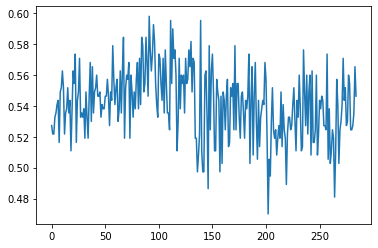

In [38]:
plt.plot(test_hist_acc)
plt.show()

In [40]:
pred.shape

torch.Size([16, 2])

In [41]:
target.shape

torch.Size([16])

In [42]:
criterion(pred, target.long())

tensor(0.1485, device='cuda:0', grad_fn=<NllLossBackward>)